# 特征工程之特征构建

---
## 1. 特征构建方法

## 具体步骤

1. **预处理**。读取数据，进行简单的变量分析后进行预处理。

   例如：缺失值替换、删除单值列

2. **加工特征**。结合业务知识进行头脑风暴，在原有特征的基础上进行组合映射。

   例如：

   加减乘除  比值 部分特征除以年龄|工龄|家庭人数会更有实际意义

              乘积 家庭负担可以用家庭人数乘以地区的消费水平

   统计量   对于多个近似等价的字段可以用 mean|max|min|std|空缺数|max/min 来代替

   分组统计 不同职业学历收入等统计项的中位数，进而可以加工原特征/此特征来表示在同业中的表现

3. **数字独热化**。将一些分类变量转化为独热表示。

   在独热化的时候要注意 分类变量的实际取值与样本中的取值是否一致。如果样本中没有覆盖完全，需要人工替换。

4. **聚合转化**。当需要加工的数据表格与原数据粒度不同时，则对其进行上述处理后，还需要进行主键转化并对一些字段进行聚合，如果表中有时间字段的话，还可以先根据距今的时间过滤后再聚合，因此可以得到近1月，近3月的表现，最后再拼接在一起。

5. **变化趋势**。近3月的收入信贷比/近6月收入信贷比，以及同比环比等都可以根据具体情况加入。

---
## 2. python实现

## 数据读取

In [21]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [22]:
train_path = './data/application_train_part.csv'
test_path = './data/application_test_part.csv'
cm_path = './data/chinese_meaning.csv'

In [23]:
# 读取训练集
application_train = pd.read_csv(train_path)
# 读取测试集
application_test = pd.read_csv(test_path)

print("训练集行列数为：{0}，测试集行列数为：{1}".format(application_train.shape, application_test.shape))

训练集行列数为：(10000, 122)，测试集行列数为：(1000, 121)


In [24]:
# 数据展示
application_train.head(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
5,100008,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
6,100009,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,...,0,0,0,0,0.0,0.0,0.0,1.0,1.0,2.0
7,100010,0,Cash loans,M,Y,Y,0,360000.0,1530000.0,42075.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
8,100011,0,Cash loans,F,N,Y,0,112500.0,1019610.0,33826.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
9,100012,0,Revolving loans,M,N,Y,0,135000.0,405000.0,20250.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# 合并训练集与测试集
df = application_train.append(application_test).reset_index(drop=True)

print("合并后数据集行列数为：{0}".format(df.shape))

合并后数据集行列数为：(11000, 122)


In [26]:
# 为了方便理解，这里导入部分字段的中文解释
chinese_meaning = pd.read_csv(cm_path)
chinese_dic = chinese_meaning.set_index('字段').to_dict()['含义']
chinese_dic

{'SK_ID_CURR': '此次申请的ID',
 'TARGET': '申请人本次申请的还款风险：1-风险较高；0-风险较低',
 'NAME_CONTRACT_TYPE': '贷款类型：cash(现金)还是revolving(周转金，一次申请，多次循环提取)',
 'CODE_GENDER': '申请人性别',
 'FLAG_OWN_CAR': '申请人是否有车',
 'FLAG_OWN_REALTY': '申请人是否有房',
 'CNT_CHILDREN': '申请人子女个数',
 'AMT_INCOME_TOTAL': '申请人收入状况',
 'AMT_CREDIT': '此次申请的贷款金额',
 'AMT_ANNUITY': '贷款年金',
 'AMT_GOODS_PRICE': '如果是消费贷款，改字段表示商品的实际价格',
 'NAME_TYPE_SUITE': '申请人此次申请的陪同人员',
 'NAME_INCOME_TYPE': '申请人收入类型',
 'NAME_EDUCATION_TYPE': '申请人受教育程度',
 'NAME_FAMILY_STATUS': '申请人婚姻状况',
 'NAME_HOUSING_TYPE': '申请人居住状况（租房，已购房，和父母一起住等）',
 'REGION_POPULATION_RELATIVE': '申请人居住地人口密度，已标准化',
 'DAYS_BIRTH': '申请人出生日（距离申请当日的天数，负值）',
 'DAYS_EMPLOYED': '申请人当前工作的工作年限（距离申请当日的天数，负值）',
 'DAYS_REGISTRATION': '申请人最近一次修改注册信息的时间（距离申请当日的天数，负值）',
 'DAYS_ID_PUBLISH': '申请人最近一次修改申请贷款的身份证明文件的时间（距离申请当日的天数，负值）',
 'FLAG_MOBIL': '申请人是否提供个人电话（1-yes，0-no）',
 'FLAG_EMP_PHONE': '申请人是否提供家庭电话（1-yes，0-no）',
 'FLAG_WORK_PHONE': '申请人是否提供工作电话（1-yes，0-no）',
 'FLAG_CONT_MOBILE': '申请人个人电话是否能拨通（1-yes，0-no）',


### 简单统计描述

In [27]:
feat_type = []
for feat in df.columns.tolist():
    feat_type.append(str(df[feat].dtype))
    
set(feat_type)

{'float64', 'int64', 'object'}

#### pandas中series对象的三个常用统计描述方法

In [28]:
df['CODE_GENDER'].value_counts()

F    7234
M    3766
Name: CODE_GENDER, dtype: int64

In [29]:
pd.value_counts?
# 如果想得出计数占比，设置参数 normalize=True
# 如果想升序排列，设置参数 ascending = True

Signature:
pd.value_counts(
    values,
    sort=True,
    ascending=False,
    normalize=False,
    bins=None,
    dropna=True,
)
Docstring:
Compute a histogram of the counts of non-null values.

Parameters
----------
values : ndarray (1-d)
sort : boolean, default True
    Sort by values
ascending : boolean, default False
    Sort in ascending order
normalize: boolean, default False
    If True then compute a relative histogram
bins : integer, optional
    Rather than count values, group them into half-open bins,
    convenience for pd.cut, only works with numeric data
dropna : boolean, default True
    Don't include counts of NaN

Returns
-------
value_counts : Series
File:      ~/anaconda3/lib/python3.7/site-packages/pandas/core/algorithms.py
Type:      function


In [30]:
df['DAYS_BIRTH'].describe()

count    11000.000000
mean    -16006.596818
std       4345.522540
min     -25160.000000
25%     -19581.750000
50%     -15757.000000
75%     -12345.000000
max      -7705.000000
Name: DAYS_BIRTH, dtype: float64

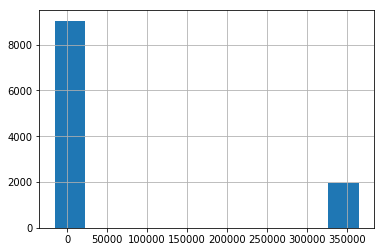

In [31]:
df['DAYS_EMPLOYED'].hist()

In [ ]:
def var_analyse(df):
    dic = {}
    for feat in df.columns.tolist():
        if df[feat].dtype == 'object' or df[feat].unique().shape[0]<=10:
            print('特征名：'+feat,df[feat].dtype)
            if feat in chinese_dic:
                print('中文含义：'+chinese_dic[feat])
            dic[feat] =  df[feat].value_counts(dropna=False,normalize=True).map(lambda x:format(x,'.2%')).reset_index(name='占比').rename(columns={'index':'取值'})
            print(dic[feat],'\n')
        else:
            print('特征名：'+feat,df[feat].dtype)
            if feat in chinese_dic:
                print('中文含义：'+chinese_dic[feat])
            dic[feat] =  df[feat].describe()
            print(df[feat].describe(),'\n')
    return(dic)

analy_dic = var_analyse(df)

### 数据清洗

In [33]:
# 将所有列的缺失值统一成nan
df['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace=True)
df['ORGANIZATION_TYPE'].replace('XNA', np.nan, inplace=True)
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

### 特征构建

方法：结合业务知识进行头脑风暴，在原有特征的基础上进行组合映射

In [34]:
# 字段清单
chinese_meaning

,字段,含义
0,SK_ID_CURR,此次申请的ID
1,TARGET,申请人本次申请的还款风险：1-风险较高；0-风险较低
2,NAME_CONTRACT_TYPE,贷款类型：cash(现金)还是revolving(周转金，一次申请，多次循环提取)
3,CODE_GENDER,申请人性别
4,FLAG_OWN_CAR,申请人是否有车
5,FLAG_OWN_REALTY,申请人是否有房
6,CNT_CHILDREN,申请人子女个数
7,AMT_INCOME_TOTAL,申请人收入状况
8,AMT_CREDIT,此次申请的贷款金额
9,AMT_ANNUITY,贷款年金


In [35]:
# 检索特征
def check_feat(feat_list):
    for feat in feat_list:
        print('特征名：',feat)
        if feat in chinese_dic:
            print('中文含义：',chinese_dic[feat])
        if feat in analy_dic:
            print(analy_dic[feat],'\n')

feat_list = ["AMT_REQ_CREDIT_BUREAU_HOUR","FLAG_MOBIL",
           "FLAG_CONT_MOBILE"]
#feat_list = [f_ for f_ in analy_dic if 'FLAG' in f_]
check_feat(feat_list)


特征名： AMT_REQ_CREDIT_BUREAU_HOUR
中文含义： 申请人发起申请前1个小时以内，被查询征信的次数
    取值      占比
0  0.0  85.97%
1  NaN  13.45%
2  1.0   0.56%
3  2.0   0.02% 

特征名： FLAG_MOBIL
中文含义： 申请人是否提供个人电话（1-yes，0-no）
   取值       占比
0   1  100.00% 

特征名： FLAG_CONT_MOBILE
中文含义： 申请人个人电话是否能拨通（1-yes，0-no）
   取值      占比
0   1  99.83%
1   0   0.17% 



#### 1. 加减乘除 

In [36]:
# 占比 部分特征除以年龄|工龄|家庭人数会更有实际意义
df['DAYS_EMPLOYED_AGE'] = df['DAYS_EMPLOYED'] / (df['DAYS_BIRTH'])                 # 在职时长/生日时长

df['PHONE_TO_BIRTH_PERC'] = df['DAYS_LAST_PHONE_CHANGE'] / (df['DAYS_BIRTH'])      #上次变更电话号码时长/生日时长
df['PHONE_TO_BIRTH_PERC'] = df['DAYS_LAST_PHONE_CHANGE'] / (df['DAYS_EMPLOYED'])   #上次变更电话号码时长/在职时长

df['CAR_TO_BIRTH_PERC'] = df['OWN_CAR_AGE'] / (df['DAYS_BIRTH'])          #车龄/生日时长
df['CAR_TO_EMPLOY_PERC'] = df['OWN_CAR_AGE'] / (df['DAYS_EMPLOYED'] )     #车龄/在职时长

df["DAYS_ID_PUBLISH_BIRTH_PERC"] = df["DAYS_ID_PUBLISH"] / (df['DAYS_BIRTH'] )         #修改申请贷款的身份证时长/生日时长
df['DAYS_ID_PUBLISH_TO_EMPLOYED_PERC'] = df['DAYS_ID_PUBLISH'] / (df['DAYS_EMPLOYED']) #修改申请贷款的身份证时长/在职时长

df['DAYS_REG_TO_BIRTH_PERC'] = df['DAYS_REGISTRATION'] /  (df['DAYS_BIRTH'] )           #申请人最近一次修改注册信息的时长/生日时长
df["DAYS_REGISTRATION_EMPLOYED_PERC"] = df["DAYS_REGISTRATION"] / (df['DAYS_EMPLOYED']) #申请人最近一次修改注册信息的时长/在职时长


df['OBS_30_SC_TO_BIRTH_PERC'] = df['OBS_30_CNT_SOCIAL_CIRCLE'] / (df['DAYS_BIRTH'])
df['DEF_30_SC_TO_EMPLOY_PERC'] = df['DEF_30_CNT_SOCIAL_CIRCLE'] / (df['DAYS_EMPLOYED'])

df['AMT_REQ_CREDIT_YEAR_TO_BIRTH_PERC'] = df['AMT_REQ_CREDIT_BUREAU_YEAR'] / (df['DAYS_BIRTH'])
df['AMT_REQ_CREDIT_YEAR_TO_EMPLOY_PERC'] = df['AMT_REQ_CREDIT_BUREAU_YEAR'] / (df['DAYS_EMPLOYED'])

df["DEF_30B60_PERC"] = df["DEF_30_CNT_SOCIAL_CIRCLE"] /(df["DEF_60_CNT_SOCIAL_CIRCLE"])
df["OBS_30B60_PERC"] = df["OBS_30_CNT_SOCIAL_CIRCLE"] /(df["OBS_60_CNT_SOCIAL_CIRCLE"] )

df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / (df['AMT_CREDIT'])      #客户收入/客户贷款额度
df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / (df['AMT_INCOME_TOTAL'])    #贷款年金/客户收入
df['ANNUITY_CREDIT_PERC'] = df['AMT_ANNUITY'] / (df['AMT_CREDIT'] )         #贷款年金/信贷额度

df["BASEMENTAREA_FAM_PERC"] = df["BASEMENTAREA_AVG"] / (df['CNT_FAM_MEMBERS'])        #人均居住面积
df["CHILDREN_FAM_PERC"] = df["CNT_CHILDREN"]/ (df['CNT_FAM_MEMBERS'])                 #孩子占家庭的比重\
df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / (df['CNT_FAM_MEMBERS'])       # 客户收入/家庭人数，人均可支配收入

In [37]:
# 乘积 家庭负担可以用家庭人数乘以地区等级
df['REGION_POPULATION_CNT_CHILDREN_MUL'] = df['CNT_CHILDREN'] * df['REGION_POPULATION_RELATIVE']
df['REGION_POPULATION_CNT_FAM_MEMBERS_MUL'] = df['CNT_FAM_MEMBERS'] * df['REGION_POPULATION_RELATIVE']
df['CHILDREN_REGION_RATING_MUL'] = df['CNT_CHILDREN'] * df['REGION_RATING_CLIENT']
df['CHILDREN_REGION_RATING_CLIENT_W_CITY_MUL'] = df['CNT_CHILDREN'] * df['REGION_RATING_CLIENT_W_CITY']
df['FAMILY_REGION_RATING_MUL'] = df['CNT_FAM_MEMBERS'] * df['REGION_RATING_CLIENT']
df['FAMILY_REGION_RATING_CLIENT_W_CITY_MUL'] = df['CNT_FAM_MEMBERS'] * df['REGION_RATING_CLIENT_W_CITY']

#### 2. 统计量 对于多个近似等价的字段可以用 mean|max|min|std|空缺数|max/min 等来代替

In [38]:
df['EXT_SOURCES_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1) #外部数据的均值
df['EXT_SOURCES_MAX'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].max(axis=1) #外部数据的最大
df['EXT_SOURCES_MIN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].min(axis=1) #外部数据的最小
df['EXT_SOURCES_PERC'] = df["EXT_SOURCES_MIN"] / df["EXT_SOURCES_MAX"]
df['EXT_SOURCES_NULL_NUM'] = np.sum(df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].isnull(),axis=1) #外部数据的均值

df['SCORES_STD'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
df['SCORES_STD'] = df['SCORES_STD'].fillna(df['SCORES_STD'].mean())


df['EXT_SOURCES_MEAN_BIRTH_PERC'] = df['EXT_SOURCES_MEAN'] / (df["DAYS_BIRTH"])
df['EXT_SOURCES_MEAN_ANNUITY_PERC'] = df['EXT_SOURCES_MEAN'] / (df["AMT_ANNUITY"])
df['EXT_SOURCES_MEAN_CREDIT_PERC'] = df['EXT_SOURCES_MEAN'] / (df["AMT_CREDIT"])


df['EXT1_AMT_INCOME_TOTAL'] = df['AMT_INCOME_TOTAL'] * df['EXT_SOURCES_MEAN']
df['EXT1_AMT_GOODS_PRICE'] = df['AMT_GOODS_PRICE'] * df['EXT_SOURCES_MEAN']

df['CREDIT_GOODS_PERC'] = df['AMT_CREDIT'] / (df['AMT_GOODS_PRICE'])  # 信贷/购物价格
df['CREDIT_PER_PERSON'] = df['AMT_CREDIT'] / df['CNT_FAM_MEMBERS']
df['CREDIT_PER_CHILD'] = df['AMT_CREDIT'] / (1 + df['CNT_CHILDREN'])



df["LIVINGAREA_PERC"] = df["LIVINGAREA_AVG"]/(df["NONLIVINGAREA_AVG"]) #居住面积和非居住面积比值


docs = [_f for _f in df.columns if 'FLAG_DOC' in _f]
live = [_f for _f in df.columns if ('FLAG_' in _f) & ('FLAG_DOC' not in _f) & ('_FLAG_' not in _f)]
df['NEW_DOC_IND_MEAN'] = df[docs].mean(axis=1)
df['NEW_DOC_IND_NULL'] = np.sum(df[docs].isnull(),axis=1)
df['NEW_LIVE_IND_MEAN'] = df[live].mean(axis=1)
df['NEW_LIVE_IND_NULL'] = np.sum(df[live].isnull(),axis=1)

df["DAYS_BIRTH"] = (df["DAYS_BIRTH"]/-365).astype(int) #转化成年龄

#### 3. 同类中位数 不同职业学历收入等统计项的中位数，进而可以加工原特征/此特征来表示在同业中的表现

In [39]:
for bin_feature in ["NAME_EDUCATION_TYPE","ORGANIZATION_TYPE","OCCUPATION_TYPE","NAME_INCOME_TYPE",
                    "NAME_CONTRACT_TYPE"]: #统计不同学历和不同职业的各种统计项:
    for item in ["AMT_INCOME_TOTAL","AMT_CREDIT","AMT_ANNUITY"]:#统计项：年金信贷比，收入信贷比，年金，信贷
        temp = df.groupby(bin_feature)[item].median()
        df[bin_feature+"_"+item] = df[bin_feature].map(temp)

### 删除无用列

将特征加工后的无用列删除

In [40]:
dropcolum=[ 'FLAG_DOCUMENT_2','FLAG_DOCUMENT_4',
            'FLAG_DOCUMENT_5','FLAG_DOCUMENT_6','FLAG_DOCUMENT_7',
            'FLAG_DOCUMENT_8','FLAG_DOCUMENT_9','FLAG_DOCUMENT_10',
            'FLAG_DOCUMENT_11','FLAG_DOCUMENT_12','FLAG_DOCUMENT_13',
            'FLAG_DOCUMENT_14','FLAG_DOCUMENT_15','FLAG_DOCUMENT_16',
            'FLAG_DOCUMENT_17','FLAG_DOCUMENT_18','FLAG_DOCUMENT_19',
            'FLAG_DOCUMENT_20','FLAG_DOCUMENT_21',
           "AMT_REQ_CREDIT_BUREAU_HOUR","FLAG_MOBIL",
           "FLAG_CONT_MOBILE"]
df= df.drop(dropcolum,axis=1)

### 数字独热化

将一些分类变量转化为独热表示。


在独热化的时候要注意 分类变量的实际取值与样本中的取值是否一致。如果样本中没有覆盖完全，需要人工替换

In [41]:
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [42]:
for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    df[bin_feature], uniques = pd.factorize(df[bin_feature])
# Categorical features with One-Hot encode

df, cat_cols = one_hot_encoder(df, nan_as_category=False)

In [43]:
print('特征维度由{0}维提升至{1}维，提升{2}维'.format(application_test.shape[1],df.shape[1],df.shape[1]-application_test.shape[1]))

特征维度由121维提升至275维，提升154维


## 融入其他数据源

In [44]:
bureau_balance_path = './data/bureau_balance_part.csv'

bb_data = pd.read_csv(bureau_balance_path)
bb_data.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS,SK_ID_CURR
0,5718975,-1,X,103173.0
1,5718975,-2,X,103173.0
2,5718975,-3,X,103173.0
3,5718975,-4,X,103173.0
4,5718975,-5,X,103173.0


**字段含义**

* SK_ID_CURR: 此次申请的ID
* SK_BUREAU_ID：信贷局每次申请的ID
* MONTHS_BALANCE 结算月份
* STATUS 信贷局当月贷款状况(C表示关闭，X表示状态未知，0表示无DPD, 1表示1-30个月期间最大，2表示DPD 31-60，…5表示DPD 120+或已出售或注销])

In [45]:
dic = var_analyse(bb_data)

特征名：SK_ID_BUREAU int64
count    6.661230e+05
mean     6.011744e+06
std      4.991024e+05
min      5.001876e+06
25%      5.690449e+06
50%      6.040825e+06
75%      6.420814e+06
max      6.842689e+06
Name: SK_ID_BUREAU, dtype: float64 

特征名：MONTHS_BALANCE int64
count    666123.000000
mean        -27.917823
std          21.755399
min         -96.000000
25%         -41.000000
50%         -23.000000
75%         -10.000000
max           0.000000
Name: MONTHS_BALANCE, dtype: float64 

特征名：STATUS object
  取值      占比
0  C  47.05%
1  0  30.33%
2  X  21.32%
3  1   0.92%
4  5   0.25%
5  2   0.07%
6  3   0.03%
7  4   0.02% 

特征名：SK_ID_CURR float64
中文含义：此次申请的ID
count    666123.000000
mean     105069.900053
std        3150.211993
min      100001.000000
25%      102419.000000
50%      104757.000000
75%      107291.000000
max      111632.000000
Name: SK_ID_CURR, dtype: float64 



In [46]:
# 预处理
bb_data = bb_data[(bb_data['STATUS'] != 'X') & (bb_data['STATUS'] != 'C')]

bb_data["STATUS"], uniques = pd.factorize(bb_data["STATUS"])
bb_data["MONTHS_BALANCE"] = abs(bb_data["MONTHS_BALANCE"])

# 按时段分类统计
bins = [0,2,4,12,24,36]
bins = bins + [bb_data["MONTHS_BALANCE"].max()]
labels = ["2MON","4MON","12MON","24MON","36MON","ABOVE"]
bb_data["MON_INTERVAL"] = pd.cut(bb_data["MONTHS_BALANCE"], bins,labels=labels)
feature = pd.pivot_table(bb_data,index=["SK_ID_CURR"],columns=["MON_INTERVAL"],values=["STATUS"],aggfunc=[np.max,np.mean,np.std]).astype('float32')
feature.columns = ["_".join(f_).upper() for f_ in feature.columns]

### **聚合转化**
当需要加工的数据表格与原数据粒度不同时，还需要进行主键转化并对一些字段进行聚合。

In [47]:
bb_agg = bb_data.groupby('SK_ID_CURR').agg({'MONTHS_BALANCE': ['min', 'max', 'size']}).astype('float64')
bb_agg.columns = [f_[0] + "_" + f_[1].upper() for f_ in bb_agg.columns.tolist()]
feature = pd.merge(feature,bb_agg,how="left",left_index=True,right_index=True)


feature = pd.merge(df,feature,on="SK_ID_CURR",how="left")

In [48]:
print('特征维度由{0}维提升至{1}维，提升{2}维'.format(df.shape[1],feature.shape[1],feature.shape[1]-df.shape[1]))

特征维度由275维提升至296维，提升21维


In [51]:
feature.to_csv('./data/featured_data.csv',index=False)